Chia-Wei Lai | clai2
<h3><center>Simulation Methods</center></h3>
<h3><center>46-773</center></h3>
<h3><center>Homework #3</center></h3>

In [56]:
import numpy as np
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
from scipy.linalg import expm
import matplotlib.pyplot as plt
import scipy.stats as stats

1) **Practice on the Aliasing Algorithm and Introduction to Credit Risk**

This problem is based on the paper “A Markov model for the term structure of credit risk spreads,” by Jarrow, Lando, and Turnbull (JLT), and the numerical values are drawn directly from that paper. The model will be presented in the Lecture 4 slides, so only an abbreviated description is given here. The idea is that we want to model the changes in bond ratings over time, and from those changes we wish to model to estimate the probability of default before maturity. JLT model this using a standard continuous time Markov chain, i.e. a particular bond has one of 8 ratings (AAA = 1, AA = 2, A = 3, BBB = 4, BB = 5, B = 6, CCC = 7, D = 8) where we consider the rating D (8) to refer to “default.” Under this model, a bond has one of 8 ratings and holds that rating for an exponential period of time, the parameter of which depends upon the rating. At the end of that holding time, its rating transitions to a new rating according to a transition probability matrix. Table 4, p507 of JLT gives the generator matrix for this Markov chain, Q, given by:

![ic_value](img/Q.png)

The holding times in each state are exponential with parameters (.1154, .1043, .1172, .1711, .2530, .1929, .4318, 0). The embedded instantaneous transition probability matrix is

![ic_value](img/P.png)


These numerical values will be uploaded on Canvas where you can copy/paste them, so you do not have to type them in if you don’t want to.

a) Write a Python program to estimate $p_{ij}(t)$, the probability that a bond with initial rating $i$ at time 0 has rating $i$ at time $t$, $1\leq i\leq 7$ and $1 \leq j \leq 8$. For purposes of credit risk, we are especially interested in $p_{i8}(5)$, $1 \leq i \leq 7$, the probability of default within the 5 year period. Clearly $P_{88}(t) = 1$. Use $t = 5$ and for each $1 \leq i \leq 7$ use $n = 1,000,000$ independent bond rating sample paths. Note that in this part of the problem, the system is Markov and the holding times in each state are exponential. Hence $P (t) = (p_{ij} (t)) = exp(Q ∗ t)$. You should use the aliasing algorithm to jump to a new state when the holding time elapses before $t = 5$ and the path must jump to a new state. You should compare the output of your simulation with the closed form solution as a way to debug your program. Recall that each entry in your matrix is the average of n coin flip experiments (the trajectory starting in $i$ ended in $j$ or it did not). As such the standard error of your estimate is the standard error from Bernoulli data, namely $\sqrt{\hat{p}_{ij}(1-\hat{p}_{ij})/n}$.

In [57]:
# Generator matrix Q
Q = np.array([
    [-0.1154, 0.1019, 0.0083, 0.0020, 0.0031, 0, 0, 0],
    [0.0091, -0.1043, 0.0787, 0.0105, 0.0030, 0.0030, 0, 0],
    [0.0010, 0.0309, -0.1172, 0.0688, 0.0107, 0.0048, 0, 0.0010],
    [0.0007, 0.0047, 0.0713, -0.1711, 0.0701, 0.0174, 0.0020, 0.0049],
    [0.0005, 0.0025, 0.0089, 0.0813, -0.2530, 0.1181, 0.0144, 0.0273],
    [0, 0.0021, 0.0034, 0.0073, 0.0568, -0.1929, 0.0479, 0.0753],
    [0, 0, 0.0142, 0.0142, 0.0250, 0.0928, -0.4318, 0.2856],
    [0, 0, 0, 0, 0, 0, 0, 0]
])

# Define the transition probability matrix P
P = np.array([
    [0, 0.8838, 0.0720, 0.0173, 0.0269, 0, 0, 0],
    [0.0872, 0, 0.7545, 0.1007, 0.0288, 0.0288, 0, 0],
    [0.0085, 0.2637, 0, 0.5870, 0.0913, 0.0410, 0, 0.0085],
    [0.0041, 0.0275, 0.4167, 0, 0.4097, 0.1017, 0.0117, 0.0286],
    [0.0020, 0.0099, 0.0352, 0.3213, 0, 0.4668, 0.0569, 0.1079],
    [0, 0.0109, 0.0176, 0.0379, 0.2946, 0, 0.2484, 0.3906],
    [0, 0, 0.0329, 0.0329, 0.0579, 0.2149, 0, 0.6614],
    [0, 0, 0, 0, 0, 0, 0, 1]
])

# Holding time parameters
holding_times = np.array([0.1154, 0.1043, 0.1172, 0.1711, 0.2530, 0.1929, 0.4318, 0])

In [58]:
# Function to create alias table
def create_alias_table(prob):
    n = len(prob)
    prob = np.array(prob) * n
    alias = np.zeros(n, dtype=int)
    small = []
    large = []
    for i, p in enumerate(prob):
        if p < 1.0:
            small.append(i)
        else:
            large.append(i)
    while small and large:
        s = small.pop()
        l = large.pop()
        alias[s] = l
        prob[l] = prob[l] - (1.0 - prob[s])
        if prob[l] < 1.0:
            small.append(l)
        else:
            large.append(l)
    return prob, alias

# Generate alias tables for each row in P
alias_tables = [create_alias_table(row) for row in P]

# Function to sample next state
def alias_sample(prob, alias):
    n = len(prob)
    i = np.random.randint(n)
    if np.random.rand() < prob[i]:
        return i
    else:
        return alias[i]

In [59]:
# Define the holding time parameters
holding_times = np.array([0.1154, 0.1043, 0.1172, 0.1711, 0.2530, 0.1929, 0.4318, 0])

# Define the time period
t = 5

# Number of sample paths
n = 1000000

def exponential_dis(holding_times, state):
    return np.random.exponential(1 / holding_times[state])

# Function to simulate one path using P
def simulate_path(init_state, P, holding_times, t, time_dis):
    state = init_state
    time_elapsed = 0
    while time_elapsed < t:

        holding_time = time_dis(holding_times, state)
        time_elapsed += holding_time
        if time_elapsed >= t:
            break
        # Get the transition probabilities for the current state
        # transition_probabilities = P[state]
        # state = np.random.choice(8, p=transition_probabilities)
        prob, alias = alias_tables[state]
        state = alias_sample(prob, alias)
        if state == 7:
            break
    return state

# Simulate n paths for each initial state
results = np.zeros((7, 8))
for i in range(7):
    for _ in range(n):
        final_state = simulate_path(i, P, holding_times, t, exponential_dis)
        results[i, final_state ] += 1
    results[i] /= n

# Print the probabilities
print("Estimated transition probabilities (P(t)):")
print(results)

# Probabilities of default within 5 years
default_probabilities_exp = results[:, 7]
print("Probabilities of default within 5 years (pi8(5)):")
print(default_probabilities_exp)


Estimated transition probabilities (P(t)):
[[0.568160 0.300689 0.084767 0.024372 0.012668 0.006199 0.000658 0.002487]
 [0.027173 0.619925 0.240152 0.067079 0.020934 0.016396 0.001628 0.006713]
 [0.005302 0.095801 0.608372 0.185086 0.052215 0.031606 0.003665 0.017953]
 [0.002964 0.029532 0.190299 0.487126 0.141568 0.080793 0.011624 0.056094]
 [0.001881 0.013011 0.056610 0.162464 0.338310 0.220535 0.033410 0.173779]
 [0.000412 0.008002 0.021551 0.042825 0.107284 0.429476 0.058950 0.331500]
 [0.000279 0.004185 0.029871 0.034501 0.046548 0.120925 0.127754 0.635937]]
Probabilities of default within 5 years (pi8(5)):
[0.002487 0.006713 0.017953 0.056094 0.173779 0.331500 0.635937]


In [60]:
print(f"stdErr = \n{np.sqrt(results * (1 - results) / n)}")

stdErr = 
[[0.000495 0.000459 0.000279 0.000154 0.000112 0.000078 0.000026 0.000050]
 [0.000163 0.000485 0.000427 0.000250 0.000143 0.000127 0.000040 0.000082]
 [0.000073 0.000294 0.000488 0.000388 0.000222 0.000175 0.000060 0.000133]
 [0.000054 0.000169 0.000393 0.000500 0.000349 0.000273 0.000107 0.000230]
 [0.000043 0.000113 0.000231 0.000369 0.000473 0.000415 0.000180 0.000379]
 [0.000020 0.000089 0.000145 0.000202 0.000309 0.000495 0.000236 0.000471]
 [0.000017 0.000065 0.000170 0.000183 0.000211 0.000326 0.000334 0.000481]]


In [61]:
# Calculate transition probability matrix P(t) = exp(Q * t)
P_t = expm(Q * t)
print(f"Transition Probability Matrix P(t=5):\n{P_t}")

Transition Probability Matrix P(t=5):
[[0.568493 0.300650 0.084463 0.024180 0.012511 0.006202 0.000642 0.002477]
 [0.027357 0.619661 0.240257 0.066931 0.021033 0.016444 0.001624 0.006681]
 [0.005355 0.095353 0.608999 0.184625 0.052265 0.031674 0.003655 0.018065]
 [0.003012 0.029545 0.190720 0.486208 0.141782 0.081392 0.011600 0.055720]
 [0.001745 0.013086 0.056421 0.162732 0.338470 0.220383 0.033334 0.173750]
 [0.000421 0.007885 0.021579 0.043192 0.107384 0.429889 0.059074 0.330245]
 [0.000274 0.004136 0.029671 0.034581 0.046814 0.120850 0.127720 0.635906]
 [0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 0.000000 1.000000]]


b) Estimate the bond rating transition probability matrix $P (5)$ assuming that the holding times are: $\frac{1}{2}$ Gamma($2$, $\lambda_i$ ), where the $\{\lambda_i \}$ are the same as in part (a). Compare with the results of part (a), what major difference do you see and why?

In [62]:
def gamma_dis(holding_times, state):
    return 0.5 * np.random.gamma(2, 1 / holding_times[state])

# Simulate n paths for each initial state
results = np.zeros((7, 8))
for i in range(7):
    for _ in range(n):
        final_state = simulate_path(i, P, holding_times, t, gamma_dis)
        results[i, final_state ] += 1
    results[i] /= n

# Print the probabilities
print("Estimated transition probabilities (P(t)):")
print(results)

# Probabilities of default within 5 years
default_probabilities_gamma = results[:, 7]
print("Probabilities of default within 5 years (pi8(5)):")
print(default_probabilities_gamma)


Estimated transition probabilities (P(t)):
[[0.681460 0.261754 0.037530 0.009000 0.007696 0.001910 0.000167 0.000483]
 [0.022403 0.727303 0.193889 0.035433 0.010045 0.008948 0.000519 0.001460]
 [0.003346 0.080846 0.690572 0.164408 0.034255 0.018654 0.001312 0.006607]
 [0.002304 0.019608 0.194579 0.521373 0.153157 0.069533 0.008142 0.031304]
 [0.001584 0.009930 0.045251 0.189791 0.320989 0.265558 0.033104 0.133793]
 [0.000191 0.006678 0.016133 0.036593 0.123589 0.462889 0.071918 0.282009]
 [0.000143 0.002564 0.032020 0.035261 0.050679 0.148871 0.082848 0.647614]]
Probabilities of default within 5 years (pi8(5)):
[0.000483 0.001460 0.006607 0.031304 0.133793 0.282009 0.647614]


In [63]:
print((default_probabilities_gamma - default_probabilities_exp))
print('We see defualt rate from gamma is lower than defualt rate from exponential')

[-0.002004 -0.005253 -0.011346 -0.024790 -0.039986 -0.049491 0.011677]
We see defualt rate from gamma is lower than defualt rate from exponential


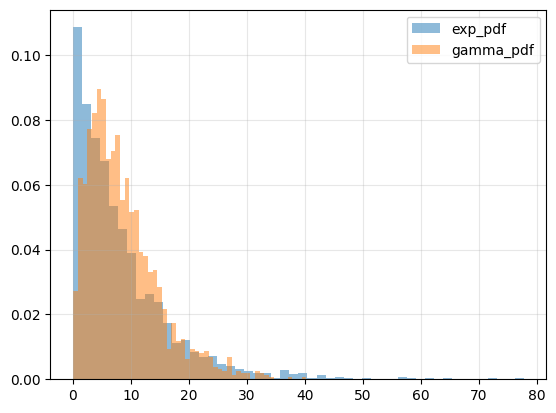

In [64]:
sample_exp = np.random.exponential(1 / holding_times[0], size = 2000)
sample_gamma = 0.5 * np.random.gamma(2, 1 / holding_times[0], size = 2000)

plt.hist(sample_exp, bins=50, density=True, alpha = 0.5)
plt.hist(sample_gamma, bins=50, density=True, alpha = 0.5)
plt.grid(alpha = 0.3)
plt.legend(['exp_pdf', 'gamma_pdf'])

In [65]:
print(sample_exp.mean(), sample_gamma.mean())
print('Because the mean of gamma is greater than the mean of exponential, every state has more chances to stay original state.')

8.372075340541043 8.602795560889168
Because the mean of gamma is greater than the mean of exponential, every state has more chances to stay original state.


2) **Practice on antithetic variables for Black Scholes**

Consider a standard Black-Scholes problem, a European call with $S_0 = 100$,$T = 1$,$r = .05$,$\sigma = .1$. The Black-Scholes price for the at-the-money option is $6.805. Remember to give standard errors for your estimates.

a) Price this option using standard Monte Carlo methods with a sample size of $n = 1,000$ and compare with the exact price for $K = 95, 100, and 105$.

b) Using a sample size of $n = 500$, price the option using the method of antithetic variables for $K = 95, 100, 105$. Compare you results with those in part a) for all three strikes, i.e. compare the standard errors.

In [66]:
import scipy.stats as stats

# Parameters
S0 = 100
T = 1
r = 0.05
sigma = 0.1
K_values = [95, 100, 105]
n_mc = 1000  # Sample size for standard Monte Carlo
n_av = 500   # Sample size for antithetic variables

# Black-Scholes price for comparison
BS_prices = {
    95: stats.norm.cdf((np.log(S0/95) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))) * S0 - stats.norm.cdf((np.log(S0/95) + (r - sigma**2/2) * T) / (sigma * np.sqrt(T))) * 95 * np.exp(-r * T),
    100: 6.805,
    105: stats.norm.cdf((np.log(S0/105) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))) * S0 - stats.norm.cdf((np.log(S0/105) + (r - sigma**2/2) * T) / (sigma * np.sqrt(T))) * 105 * np.exp(-r * T)
}

# Standard Monte Carlo simulation
def monte_carlo_price(S0, K, T, r, sigma, n):
    Z = np.random.randn(n)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoff = np.maximum(ST - K, 0)
    C_mc = np.exp(-r * T) * np.mean(payoff)
    stderr = np.std(payoff) / np.sqrt(n)
    return C_mc, stderr

# Monte Carlo with antithetic variables
def antithetic_variates(S0, K, T, r, sigma, n):
    Z = np.random.randn(n)
    ST1 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    ST2 = S0 * np.exp((r - 0.5 * sigma**2) * T - sigma * np.sqrt(T) * Z)
    payoff = 0.5 * (np.maximum(ST1 - K, 0) + np.maximum(ST2 - K, 0))
    C_av = np.exp(-r * T) * np.mean(payoff)
    stderr = np.std(payoff) / np.sqrt(n)
    return C_av, stderr

# Run simulations
results_mc = {K: monte_carlo_price(S0, K, T, r, sigma, n_mc) for K in K_values}
results_av = {K: antithetic_variates(S0, K, T, r, sigma, n_av) for K in K_values}

# Print results
print("Standard Monte Carlo:")
for K in K_values:
    print(f"K={K}: Price={results_mc[K][0]:.4f}, StdErr={results_mc[K][1]:.4f}, Exact price={BS_prices[K]:.4f}")

print("\nAntithetic Variables:")
for K in K_values:
    print(f"K={K}: Price={results_av[K][0]:.4f}, StdErr={results_av[K][1]:.4f}, Exact price={BS_prices[K]:.4f}")


Standard Monte Carlo:
K=95: Price=10.4366, StdErr=0.2988, Exact price=10.4053
K=100: Price=6.8006, StdErr=0.2535, Exact price=6.8050
K=105: Price=4.1337, StdErr=0.2117, Exact price=4.0461

Antithetic Variables:
K=95: Price=10.3045, StdErr=0.0938, Exact price=10.4053
K=100: Price=6.7972, StdErr=0.1395, Exact price=6.8050
K=105: Price=4.0673, StdErr=0.1579, Exact price=4.0461


3) **Pricing an arithmetic Asian option**

Consider an asset price process, $\{S_t, t \geq 0\}$ governed by a geometric Brownian motion with drift $\mu = .10$ and volatility $\sigma = .1$ per year. Assume riskless interest rates are $r = .05$ and $S_0 = 100$. Suppose the interval $[0, T ]$ is divided into $N$ equal time steps of length $\Delta = N/T$ . Consider an European arithmetic Asian option averaged once per time step with strike price $K = 100$. Assume $T = 1$ and $N = 52$. Using the notation that $S_i\Delta$ is the asset price at time $i\Delta$, the option payoff is given by max($\frac{1}{N} \sum_{i=1}^{N}S_{i\Delta}−K,0$).

(a) Using standard Monte Carlo simulation with $n = 1, 000$ paths, estimate the price of this option and provide a standard error.

(b) For each path, construct an antithetic path, average the regular and the antithetic path discounted option payoffs, then provide an estimate of the price and its standard error. Use $n = 500$ rather than $n = 1,000$ for this part of the problem only.


In [67]:
# Parameters
S0 = 100
T = 1
r = 0.05
sigma = 0.1
mu = 0.10
K = 100
N = 52
Delta = T / N
n_mc = 1000  # Sample size for standard Monte Carlo
n_av = 500   # Sample size for antithetic variables

# Payoff function for the arithmetic Asian option
def arithmetic_asian_payoff(S, K):
    A = np.mean(S, axis=1)
    return np.maximum(A - K, 0)

# Monte Carlo simulation for arithmetic Asian option
def monte_carlo_asian(S0, K, T, r, sigma, mu, N, Delta, n):
    Z = np.random.randn(n, N)
    S = np.zeros((n, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma**2) * Delta + sigma * np.sqrt(Delta) * Z[:, i-1])
    payoff = arithmetic_asian_payoff(S[:, 1:], K)
    C_mc = np.exp(-r * T) * np.mean(payoff)
    stderr = np.std(payoff) / np.sqrt(n)
    return C_mc, stderr

# Monte Carlo with antithetic variables
def antithetic_asian(S0, K, T, r, sigma, mu, N, Delta, n):
    Z = np.random.randn(n, N)
    S1 = np.zeros((n, N+1))
    S2 = np.zeros((n, N+1))
    S1[:, 0] = S2[:, 0] = S0
    for i in range(1, N+1):
        S1[:, i] = S1[:, i-1] * np.exp((r - 0.5 * sigma**2) * Delta + sigma * np.sqrt(Delta) * Z[:, i-1])
        S2[:, i] = S2[:, i-1] * np.exp((r - 0.5 * sigma**2) * Delta - sigma * np.sqrt(Delta) * Z[:, i-1])
    payoff = 0.5 * (arithmetic_asian_payoff(S1[:, 1:], K) + arithmetic_asian_payoff(S2[:, 1:], K))
    C_av = np.exp(-r * T) * np.mean(payoff)
    stderr = np.std(payoff) / np.sqrt(n)
    return C_av, stderr

# Run simulations
price_mc, stderr_mc = monte_carlo_asian(S0, K, T, r, sigma, mu, N, Delta, n_mc)
price_av, stderr_av = antithetic_asian(S0, K, T, r, sigma, mu, N, Delta, n_av)

# Print results
print("Standard Monte Carlo:")
print(f"Price: {price_mc:.4f}, StdErr: {stderr_mc:.4f}")

print("\nAntithetic Variables:")
print(f"Price: {price_av:.4f}, StdErr: {stderr_av:.4f}")


Standard Monte Carlo:
Price: 3.6407, StdErr: 0.1402

Antithetic Variables:
Price: 3.6778, StdErr: 0.0766


(c) Estimate the option price using the average final price, $\bar{S}_N$ , as a control variable.

(d) Refer to the material on pages 83-86 of the Course Notes. Estimate the price of this option using
the geometric Asian option as a control variable where the price of the geometric Asian option is
given by the asymptotic formula $(N \rightarrow \infty)$, $\sigma^* = \frac{\sigma}{\sqrt{3}}$ and $d_∗ = \frac{(r+d)}{2} + \frac{\sigma}{12}$ as a control variable.


In [68]:
# Control variate using the average final price
def control_variate_final_price(S0, K, T, r, sigma, N, Delta, n):
    Z = np.random.randn(n, N)
    S = np.zeros((n, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma**2) * Delta + sigma * np.sqrt(Delta) * Z[:, i-1])
    payoff = arithmetic_asian_payoff(S[:, 1:], K)
    final_price = S[:, -1]

    cov = np.cov(final_price, payoff, ddof = 1)
    a_hat = cov[0, 1] / cov[0, 0]
    # Control variate adjustment
    control_var = payoff - a_hat * (final_price - S0 * np.exp(r * T))
    C_cv = np.exp(-r * T) * np.mean(control_var)
    stderr = np.std(control_var) / np.sqrt(n)
    return C_cv, stderr

# Geometric Asian option price
def geometric_asian_option_price(S0, K, T, r, sigma, N):
    b = 0.5 * (r - sigma**2 / 6)
    sigma_G = sigma / np.sqrt(3)
    d1_G = (np.log(S0 / K) + (b + 0.5 * sigma_G**2) * T) / (sigma_G * np.sqrt(T))
    d2_G = d1_G - sigma_G * np.sqrt(T)
    price_G = S0 * np.exp(-b * T) * stats.norm.cdf(d1_G) - K * np.exp(-r * T) * stats.norm.cdf(d2_G)
    return price_G

# Control variate using geometric Asian option
def control_variate_geometric_asian(S0, K, T, r, sigma, N, Delta, n, price_G):
    Z = np.random.randn(n, N)
    S = np.zeros((n, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((r - 0.5 * sigma**2) * Delta + sigma * np.sqrt(Delta) * Z[:, i-1])
    payoff = arithmetic_asian_payoff(S[:, 1:], K)
    # average_price = np.mean(S[:, 1:], axis=1)
    geometric_payoff = np.maximum(S[:, 1:].prod(axis = 1) ** (1 / N) - K, 0)

    cov = np.cov(geometric_payoff, payoff, ddof = 1)
    a_hat = cov[0, 1] / cov[0, 0]
    # Control variate adjustment
    control_var = payoff - a_hat * (geometric_payoff - price_G * np.exp(r * T))
    C_cv = np.exp(-r * T) * np.mean(control_var)
    stderr = np.std(control_var) / np.sqrt(n)
    return C_cv, stderr



# Calculate prices using different methods
price_cv_final, stderr_cv_final = control_variate_final_price(S0, K, T, r, sigma, N, Delta, n_mc)
price_G = geometric_asian_option_price(S0, K, T, r, sigma, N)
price_cv_geo, stderr_cv_geo = control_variate_geometric_asian(S0, K, T, r, sigma, N, Delta, n_mc, price_G)


print(f"Asian call price from final price as variable control = {price_cv_final:.4f}, stdErr =  {stderr_cv_final:.4f}")
print(f"Asian call price from analytical geo Asia call price as variable control = {price_cv_geo:.4f}, stdErr =  {stderr_cv_geo:.4f}")


Asian call price from final price as variable control = 3.7223, stdErr =  0.0805
Asian call price from analytical geo Asia call price as variable control = 3.7513, stdErr =  0.0020


In [69]:
# Corrected exact price of geometric Asian option using asymptotic formula
def corrected_exact_geometric_asian_option_price(S0, K, T, r, sigma, q, N):
    sigma_star = sigma * np.sqrt((N + 1) * (2 * N + 1) / (6 * N**2))
    d_star = (r * (N - 1) / (2 * N)) + (q * (N + 1) / (2 * N)) + (sigma**2 * (N + 1) * (N - 1) / (12 * N**2))
    d1_star = (np.log(S0 / K) + (r - d_star + 0.5 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2_star = d1_star - sigma_star * np.sqrt(T)
    exact_price = S0 * np.exp(-d_star * T) * stats.norm.cdf(d1_star) - K * np.exp(-r * T) * stats.norm.cdf(d2_star)
    return exact_price

# Calculate the corrected exact price
corrected_price_exact_geo = corrected_exact_geometric_asian_option_price(S0, K, T, r, sigma, 0, N)

corrected_price_exact_geo


3.6330831104455115

(e) Repeat part (d) only using the exact price of the geometric Asian option with $\sigma^* =\sigma \sqrt{\frac{(N+1)(2N+1)}{6N^2}}$
and $d^* =r\frac{N−1}{2N} +d \frac{N+1}{2N} + \sigma^2 (\frac{(N+1)(N−1)}{12N^2})$.


In [70]:
price_cv_geo, stderr_cv_geo = control_variate_geometric_asian(S0, K, T, r, sigma, N, Delta, n_mc, corrected_price_exact_geo)

print(f"Asian call price from exact geo Asia call price as variable control = {price_cv_geo:.4f}, stdErr =  {stderr_cv_geo:.4f}")

Asian call price from exact geo Asia call price as variable control = 3.7017, stdErr =  0.0019


Compare the results in the various parts of this problem, commenting on the effectiveness of the various variance reduction methods.

Based on the above results, we can see using geo Asia option as control variables has relatively more effective (lower stdErr) than using final stock price as control variables and antithetic variable

4) **Practice on Control Variables and Importance Sampling.**
Consider an asset whose price process is given by a geometric Brownian motion with initial price $S_0 = 100$, drift $\mu = .10$ and volatility $\sigma = 0.2$. Suppose riskless interest rates are $r = .05$. Consider a European call option with expiration $T = 1$ year and various strike prices $K$. We want to study the benefits of importance sampling when $K$ is large, and the option is out of the money. Note, other variance reduction

(a) Using Standard Monte Carlo methods with $n = 10, 000$ price this option when $K = 120, 140, 160$.


In [91]:
# Parameters
S0 = 100
mu = 0.10
sigma = 0.20
r = 0.05
T = 1
n = 100000
strike_prices = [120, 140, 160]

# Generate standard normal random variables
Z = np.random.normal(0, 1, n)

# Simulate asset prices at maturity
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

# Calculate call option prices for different strike prices
call_prices = {}
for K in strike_prices:
    payoffs = np.maximum(ST - K, 0)
    call_prices_pv = np.exp(-r * T) * payoffs
    stderr = np.std(call_prices_pv) / np.sqrt(n)
    
    call_prices[K] = np.mean(call_prices_pv), stderr


for K in strike_prices:
    print(f"K = {K}, call price = {call_prices[K][0]:.4f}, stdErr = {call_prices[K][1]:.4f}")


K = 120, call price = 3.2821, stdErr = 0.0278
K = 140, call price = 0.8083, stdErr = 0.0138
K = 160, call price = 0.1704, stdErr = 0.0063


(b) Using the put-call parity, reformulate the call pricing problem as a put pricing problem and repeat
the previous exercise.


In [92]:
# Calculate put option prices for different strike prices using Monte Carlo
put_prices = {}
for K in strike_prices:
    payoffs = np.maximum(K - ST, 0)
    put_price_pv = np.exp(-r * T) * payoffs
    call_price_pv = put_price_pv + S0 - K * np.exp(-r * T)
    stderr = np.std(put_price_pv) / np.sqrt(n)

    put_prices[K] = np.mean(put_price_pv)
    call_prices[K] = np.mean(call_price_pv), stderr

for K in strike_prices:
    print(f"K = {K}, call price = {call_prices[K][0]:.4f}, stdErr = {call_prices[K][1]:.4f}")


K = 120, call price = 3.2226, stdErr = 0.0470
K = 140, call price = 0.7488, stdErr = 0.0582
K = 160, call price = 0.1110, stdErr = 0.0625


(c) Repeat part b) using the final price, $S_T$ , as a control variable.

In [93]:
# Control variate technique
expected_ST = S0 * np.exp(r * T)
b_values = {}
adjusted_call_prices = {}

for K in strike_prices:
    payoffs = np.maximum(K - ST, 0)
    cov = np.cov(payoffs, ST)[0, 1]
    var = np.var(ST)
    b = cov / var
    adjusted_payoffs = payoffs - b * (ST - expected_ST)
    adjusted_put_price_pv = np.exp(-r * T) * adjusted_payoffs
    stderr = np.std(adjusted_put_price_pv) / np.sqrt(n)

    adjusted_call_prices[K] = np.mean(adjusted_put_price_pv) + S0 - K * np.exp(-r * T), stderr


for K in strike_prices:
    print(f"K = {K}, call price = {adjusted_call_prices[K][0]:.4f}, stdErr = {adjusted_call_prices[K][1]:.4f}")

K = 120, call price = 3.2627, stdErr = 0.0183
K = 140, call price = 0.8016, stdErr = 0.0118
K = 160, call price = 0.1685, stdErr = 0.0059


##### Appendix: timestamp

In [74]:
from datetime import datetime

print(f"Generated on {datetime.now()}")

Generated on 2024-05-21 00:51:47.156170
